versão inicial fortemente baseada em
https://pyimagesearch.com/2020/11/16/gans-with-keras-and-tensorflow/,
artigo original: https://arxiv.org/abs/1511.06434

bibliotecas utilizadas:

In [166]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Flatten

from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np
import IPython.display
import PIL.Image

from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input

import matplotlib.pyplot as plt

import random

import tensorflow_datasets as tfds

from imgaug import augmenters as iaa

import os

import itertools

Constantes:

In [167]:
genWidth = 8
genHeight = 8
genDepth = 64
noiseDim = 100
genFCOutputDim = 512
imgChannels = 3
imgWidth = 32
imgHeight = 32

leakyReluAlpha = 0.2
discFCOutputDim = 512

initLr = 2e-4
ganEpochs = 25
classifierEpochs = 8
batchSize = 128

nClasses = 12
datasetName = 'cifar10'

#validação cruzada
kFold = 5
currentFold = 0

#carrega dataset
dataset, info = tfds.load(name = datasetName, with_info=True, data_dir='D:/Documentos/UNB/TCC/tfDatasets')
total_instances = info.splits['test'].num_examples + info.splits['train'].num_examples
n_instances_fold = int(np.floor(total_instances/kFold))

trainIter = dataset['train'].as_numpy_iterator()
lastTrainId = 0
testIter = dataset['test'].as_numpy_iterator()
lastTestId = 0


Funções helper para apresentação de imagens e dados de treinamento

In [168]:
def concatArray(a, n):
    d = []
    for j in range(a.shape[1]):
        for i in range(n):
            d.append(a[i][j])
    d = np.array(d)
    d = np.reshape(d, (a.shape[1],a.shape[2]*n,a.shape[3]))
    return d

In [169]:
#mostrar input/output
def showOutputAsImg(out, n = 20):
  IPython.display.display(PIL.Image.fromarray(concatArray(out,n)).resize(size=(100*n,100)))

In [170]:
def plotLoss(losses, clear=True):
    if(clear):
        plt.clf()
    for loss in losses:
        plt.plot(loss[0], label=loss[1])
    plt.legend()
    plt.show()

In [171]:
def verifiedFolder(folderPath):
    createdFolder = folderPath
    if('.' in createdFolder.split('/')[-1]):
        createdFolder = '/'.join(createdFolder.split('/')[:-1])
    if not os.path.exists(createdFolder):
        os.makedirs(createdFolder)
    return folderPath

Cria model geradora com keras functional API

In [172]:

def makeGenerator():
    genInput = keras.Input(shape=(100,), name = 'genInput_randomDistribution')

    # cria camada de entrada, com noiseDim entradas, saída de tamanho sCOutputDim, e ativação relu
    # entrada -> tamanho escolhido
    genX = layers.Dense(genFCOutputDim, activation='relu')(genInput)
    genX = layers.BatchNormalization()(genX)

    # cria camada que converte saída da primeira camada para o número de nós necessário na entrada
    # das camadas convolucionais
    genX = layers.Dense(units=genWidth*genHeight*genDepth, activation='relu')(genX)
    genX = layers.BatchNormalization()(genX)
    labelOutput = layers.Dense(nClasses, activation='sigmoid', name='genOutput_label')(genX)

    # Faz reshape para dimensões espaciais desejadas
    genX = layers.Reshape((genWidth, genHeight, genDepth))(genX)

    # convolução transposta (genWidth,genHeight,genDepth =/ strides)
    genX = layers.Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu')(genX)
    genX = layers.BatchNormalization(axis=-1)(genX)

    # camada convolucional que tem como output a imagem de saída
    # tanh é usado pois é necessária saída de espaço limitado
    genOutput = layers.Conv2DTranspose(filters=imgChannels, kernel_size=(5,5), strides=(2,2), padding='same', activation='tanh', name = 'genOutput_img')(genX)

    generator = keras.Model(inputs = genInput, outputs = [genOutput, labelOutput], name = 'generator')

    keras.utils.plot_model(
        generator, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/generator/fold_' + str(currentFold) + '.png')
    )
    return generator

Cria model CGAN geradora com keras functional API

In [173]:
def makeCGenerator():
    cgenNoiseInput = keras.Input(shape=(100,), name = 'genInput_randomDistribution')
    cgenLabelInput = keras.Input(shape=(nClasses,), name = 'genInput_label')

    cgenX = layers.concatenate([cgenNoiseInput, cgenLabelInput])

    # cria camada de entrada, com noiseDim entradas, saída de tamanho sCOutputDim, e ativação relu
    # entrada -> tamanho escolhido
    cgenX = layers.Dense(genFCOutputDim, activation='relu')(cgenX)
    cgenX = layers.BatchNormalization()(cgenX)

    # cria camada que converte saída da primeira camada para o número de nós necessário na entrada
    # das camadas convolucionais
    cgenX = layers.Dense(units=genWidth*genHeight*genDepth, activation='relu')(cgenX)
    cgenX = layers.BatchNormalization()(cgenX)

    # Faz reshape para dimensões espaciais desejadas
    cgenX = layers.Reshape((genWidth, genHeight, genDepth))(cgenX)

    # convolução transposta (genWidth,genHeight,genDepth =/ strides)
    cgenX = layers.Conv2DTranspose(filters=32, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu')(cgenX)
    cgenX = layers.BatchNormalization(axis=-1)(cgenX)

    # camada convolucional que tem como output a imagem de saída
    # tanh é usado pois é necessária saída de espaço limitado
    cgenOutput = layers.Conv2DTranspose(filters=imgChannels, kernel_size=(5,5), strides=(2,2), padding='same', activation='tanh', name = 'genOutput_img')(cgenX)

    cgenerator = keras.Model(inputs = [cgenNoiseInput, cgenLabelInput], outputs = cgenOutput, name = 'cgenerator')

    keras.utils.plot_model(
        cgenerator, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/cgenerator/flod_' + str(currentFold) + '.png')
    )
    return cgenerator

Cria model discriminadora com functional API

In [174]:
def makeDiscriminator():
    discInput = keras.Input(shape=(imgWidth, imgHeight, imgChannels), name = 'discInput_img')

    # primeira camada convolucional, recebe formato das imagens
    discX = layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', strides=(2,2))(discInput)
    discX = layers.LeakyReLU(alpha=leakyReluAlpha)(discX)

    # segunda camada convolucional.
    discX = layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', strides=(2,2))(discX)
    discX = layers.LeakyReLU(alpha=leakyReluAlpha)(discX)
    discX = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(discX)
    # camada densa
    discX = layers.Flatten()(discX)
    discX = layers.Dropout(0.2)(discX)

    labelInput = keras.Input(shape=(nClasses,), name = 'discInput_label')
    discX = layers.concatenate([discX, labelInput])
    discX = layers.Dense(discFCOutputDim)(discX)
    discX = layers.LeakyReLU(alpha=leakyReluAlpha)(discX)

    # nó de output, sigmoid->mapear em 0 ou 1
    discOutput = layers.Dense(1, activation='sigmoid', name = 'discOutput_realVSfake')(discX)

    discriminator = keras.Model(inputs = [discInput, labelInput], outputs = discOutput, name = 'discriminator')

    keras.utils.plot_model(
        discriminator, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/discriminator/fold_' + str(currentFold) + '.png')
    )
    return discriminator

Preparando dados

In [175]:
def resizeImg(entry):
    img = entry['image']
    w = img.shape[0]
    h = img.shape[1]
    side = np.min([w,h])
    cw, ch = int(w/2 - side/2), int(h/2 - side/2)
    img = np.asarray(PIL.Image.fromarray(img[cw:cw+side, ch:ch+side]).resize(size=(100,100)))
    entry['image'] = img
    return entry

In [176]:
def loadIntoArray(datasetSection, dataset, start, end, lastTestId, lastTrainId, testIter, trainIter):
    if(dataset == 'test'):
        if(start >= lastTestId):
            testIter = itertools.islice(testIter, start - lastTestId, None)
        else:
            testIter = itertools.islice(dataset['test'].as_numpy_iterator(), start, None)
        lastTestId = end + 1
        imgs = []
        lbls = []
        for i in range(end - start):
            d = next(testIter)
            imgs.append(d['image'])
            lbls.append([int(d['label'] == n) for n in range(nClasses)])
        imgs = np.array(imgs).astype("float")
        imgs = (imgs - 127.5) / 127.5
        lbls = np.array(lbls)
        return imgs, lbls
    else:
        if(start >= lastTrainId):
            trainIter = itertools.islice(trainIter, start - lastTrainId, None)
        else:
            trainIter = itertools.islice(dataset['test'].as_numpy_iterator(), start, None)
        lastTrainId = end
        #rsdz = map(resizeImg, npI)
        imgs = []
        lbls = []
        for i in range(end - start):
            d = next(trainIter)
            imgs.append(d['image'])
            lbls.append([int(d['label'] == n) for n in range(nClasses)])
        imgs = np.array(imgs).astype("float")
        imgs = (imgs - 127.5) / 127.5
        lbls = np.array(lbls)
        return imgs, lbls

In [177]:

def getFromDataset(start, end, test=False):
    testEntries = info.splits['test'].num_examples
    trainEntries = info.splits['train'].num_examples
    totalEntries = testEntries + trainEntries
    n = int(np.floor(totalEntries/kFold))

    if(test):
        start += currentFold*n
        end += currentFold*n
    
    imgs = None
    lbls = None
    if(end < trainEntries):
        imgs, lbls = loadIntoArray('train', start, end, lastTestId, lastTrainId, testIter, trainIter)
    elif (start >= trainEntries):
        imgs, lbls = loadIntoArray('test', start - trainEntries, end - trainEntries, lastTestId, lastTrainId, testIter, trainIter)
    else:
        imgs1, lbls1 = loadIntoArray('train', start, trainEntries - 1, lastTestId, lastTrainId, testIter, trainIter)
        imgs2, lbls2 = loadIntoArray('test', 0, end - trainEntries, lastTestId, lastTrainId, testIter, trainIter)
        imgs = np.concatenate((imgs1, imgs2))
        lbls = np.concatenate((lbls1, lbls2))
        del imgs1, imgs2, lbls1, lbls2

    del testEntries, trainEntries, n, totalEntries

    return imgs, lbls

compilando gerador e gan


In [178]:
def compileGAN():
    optDiscr = Adam(learning_rate = initLr, beta_1 = 0.5, decay = initLr/ganEpochs)
    ganDiscriminator = makeDiscriminator()
    ganDiscriminator.compile(loss='binary_crossentropy', optimizer=optDiscr)

    ganGenerator = makeGenerator()
    ganDiscriminator.trainable = False
    ganInput = Input(shape=(100,))
    ganOutput = ganDiscriminator(ganGenerator(ganInput))
    gan = Model(ganInput, ganOutput)

    optGan = Adam(learning_rate=initLr, beta_1=0.5, decay=initLr/ganEpochs)
    gan.compile(loss= 'binary_crossentropy', optimizer=optGan)
    
    keras.utils.plot_model(
        gan, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/gan/fold_' + str(currentFold) + '.png')
    )
    return ganGenerator,ganDiscriminator, gan

compilando gerador condicional e cgan

In [179]:
def compileCGAN():
    optDiscr = Adam(learning_rate = initLr, beta_1 = 0.5, decay = initLr/ganEpochs)
    cganDiscriminator = makeDiscriminator()
    cganDiscriminator.compile(loss='binary_crossentropy', optimizer=optDiscr)

    cganGenerator = makeCGenerator()
    cganDiscriminator.trainable = False
    cganNoiseInput = Input(shape=(100,))
    cganLabelInput = Input(shape=(nClasses,))
    cganOutput = cganDiscriminator([cganGenerator([cganNoiseInput, cganLabelInput]), cganLabelInput])
    cgan = Model((cganNoiseInput, cganLabelInput), cganOutput)

    optcGan = Adam(learning_rate=initLr, beta_1=0.5, decay=initLr/ganEpochs)
    cgan.compile(loss= 'binary_crossentropy', optimizer=optcGan)
    
    keras.utils.plot_model(
        cgan, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/cgan/fold_' + str(currentFold) + '.png')
    )
    
    return cganGenerator,cganDiscriminator, cgan

treinamento GAN


In [180]:
def trainGAN(generator, discriminator, gan):
  benchNoise = np.random.uniform(-1,1, size=(256,100))
  genLossHist = []
  discLossHist = []

  for epoch in range(ganEpochs):
    nBatches = int((total_instances - n_instances_fold)/batchSize)
    for i in range(nBatches):
      imgBatch, labelBatch = getFromDataset(i*batchSize, (i+1)*batchSize)
      genInput = np.random.uniform(-1,1,size=(batchSize,100))
      genImgOutput, genLabelOutput = generator.predict(genInput, verbose=0)

      XImg = np.concatenate((imgBatch, genImgOutput))
      XLabel = np.concatenate((labelBatch, genLabelOutput))
      y = ([1] * batchSize) + ([0] * batchSize)
      y = np.reshape(y, (-1,))
      (XImg, XLabel, y) = shuffle(XImg, XLabel, y)
      
      discLoss = discriminator.train_on_batch([XImg,XLabel], y)
      
      genTrainNoise = np.random.uniform(-1,1,size=(batchSize,100))
      gentrainLbls = [1]*batchSize
      gentrainLbls = np.reshape(gentrainLbls, (-1,))
      ganLoss = gan.train_on_batch(genTrainNoise,gentrainLbls)
      if i == nBatches-1:
        discLossHist.append(discLoss)
        genLossHist.append(ganLoss)
        IPython.display.clear_output(True)
        print("Epoch " + str(epoch) + "\nGAN (generator training) loss: " + str(ganLoss) + "\ndiscriminator loss: " + str(discLoss))
        images, labels = generator.predict(benchNoise)
        out = ((images * 127.5) + 127.5).astype('uint8')
        showOutputAsImg(out)
        print([str(a.argmax()) + ' ' for a in labels[:20]])
        plotLoss([[genLossHist, 'generator loss'],[discLossHist, 'discriminator loss']])
    if(epoch%5 == 0 or epoch == ganEpochs-1):
      generator.save(verifiedFolder('modelSaves/' + datasetName + '/gen/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
      discriminator.save(verifiedFolder('modelSaves/' + datasetName + '/disc/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
      gan.save(verifiedFolder('modelSaves/' + datasetName + '/gan/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))

treinamento CGAN

In [181]:
def trainCGAN(generator, discriminator, cgan):
  cdiscLossHist = []
  cgenLossHist = []

  #noise e labels de benchmark
  benchNoise = np.random.uniform(-1,1, size=(256,100))
  benchLabels = np.random.randint(0,nClasses, size = (256))
  for i in range(20):
    benchLabels[i] = int(i/2)

  benchLabels = np.array([[1 if i == bl else 0 for i in range(nClasses)] for bl in benchLabels], dtype='float32')

  for epoch in range(ganEpochs):
    nBatches = int((total_instances - n_instances_fold)/batchSize)
    for i in range(nBatches):
      imgBatch, labelBatch = getFromDataset(i*batchSize, (i+1)*batchSize)
      genInput = np.random.uniform(-1,1,size=(batchSize,100))
      labelInput = np.random.randint(0,nClasses, size = (batchSize))
      labelInput = np.array([[1 if i == li else 0 for i in range(nClasses)] for li in labelInput], dtype='float32')
      genImgOutput = generator.predict([genInput, labelInput], verbose=0)

      XImg = np.concatenate((imgBatch, genImgOutput))
      XLabel = np.concatenate((labelBatch, labelInput))
      y = ([1] * batchSize) + ([0] * batchSize)
      y = np.reshape(y, (-1,))
      (XImg, XLabel, y) = shuffle(XImg, XLabel, y)
      
      discLoss = discriminator.train_on_batch([XImg,XLabel], y)
      
      genTrainNoise = np.random.uniform(-1,1,size=(batchSize,100))
      genTrainClasses = np.random.randint(0,nClasses, size = (batchSize))
      genTrainClasses = np.array([[1 if i == c else 0 for i in range(nClasses)] for c in genTrainClasses], dtype='float32')
      gentrainLbls = [1]*batchSize 
      gentrainLbls = np.reshape(gentrainLbls, (-1,))
      ganLoss = cgan.train_on_batch([genTrainNoise, genTrainClasses],gentrainLbls)

      if i == nBatches-1:
        cdiscLossHist.append(discLoss)
        cgenLossHist.append(ganLoss)
        IPython.display.clear_output(True)
        print("Epoch " + str(epoch) + "\nGAN (generator training) loss: " + str(ganLoss) + "\ndiscriminator loss: " + str(discLoss))
        images = generator.predict([benchNoise, benchLabels])
        out = ((images * 127.5) + 127.5).astype('uint8')
        showOutputAsImg(out)
        print([str(a.argmax()) + ' ' for a in benchLabels[:20]])
        plotLoss([[cgenLossHist, 'generator loss'],[cdiscLossHist, 'discriminator loss']])
    if(epoch%5 == 0 or epoch == ganEpochs-1):
      generator.save(verifiedFolder('modelSaves/' + datasetName + '/cgen/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
      discriminator.save(verifiedFolder('modelSaves/' + datasetName + '/cdisc/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
      cgan.save(verifiedFolder('modelSaves/' + datasetName + '/cgan/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))

Treinando GAN

In [182]:
gen, disc, gan = compileGAN()
trainGAN(gen, disc, gan)

StopIteration: 

In [ ]:
gen.save(verifiedFolder('modelSaves/' + datasetName + '/gen/fold_' + str(currentFold)))
disc.save(verifiedFolder('modelSaves/' + datasetName + '/disc/fold_' + str(currentFold)))
gan.save(verifiedFolder('modelSaves/' + datasetName + '/gan/fold_' + str(currentFold)))
'''
gen = load_model(verifiedFolder('modelSaves/' + datasetName + '/gen/fold_' + str(currentFold)))
disc = load_model(verifiedFolder('modelSaves/' + datasetName + '/disc/fold_' + str(currentFold)))
gan = load_model(verifiedFolder('modelSaves/' + datasetName + '/gan/fold_' + str(currentFold)))'''

del gan, disc

INFO:tensorflow:Assets written to: modelSaves/cifar10/gen/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/gen/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/disc/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/disc/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/gan/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/gan/fold_0\assets


"\ngen = load_model(verifiedFolder('modelSaves/' + datasetName + '/gen/fold_' + str(currentFold)))\ndisc = load_model(verifiedFolder('modelSaves/' + datasetName + '/disc/fold_' + str(currentFold)))\ngan = load_model(verifiedFolder('modelSaves/' + datasetName + '/gan/fold_' + str(currentFold)))"

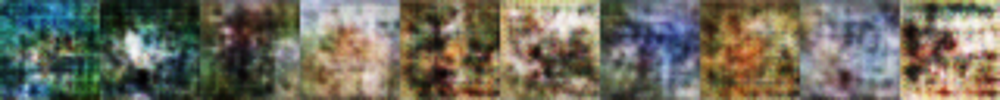

['0       ', '3       ', '9       ', '0       ', '3       ', '1       ', '3       ', '7       ', '3       ', '1       ']


In [ ]:
noise = np.random.uniform(-1,1, size=(nClasses,100))
images, lbls = gen.predict(noise)
out = ((images * 127.5) + 127.5).astype('uint8')
showOutputAsImg(out,nClasses)
print([str(np.argmax(l)) + '       ' for l in lbls[:nClasses]])

del noise, images, lbls, out

Treinando CGAN

Epoch 0
GAN (generator training) loss: 1.857834815979004
discriminator loss: 0.5799305438995361


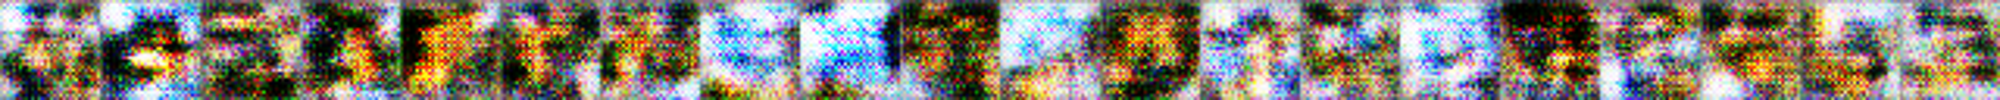

['0 ', '0 ', '1 ', '1 ', '2 ', '2 ', '3 ', '3 ', '4 ', '4 ', '5 ', '5 ', '6 ', '6 ', '7 ', '7 ', '8 ', '8 ', '9 ', '9 ']


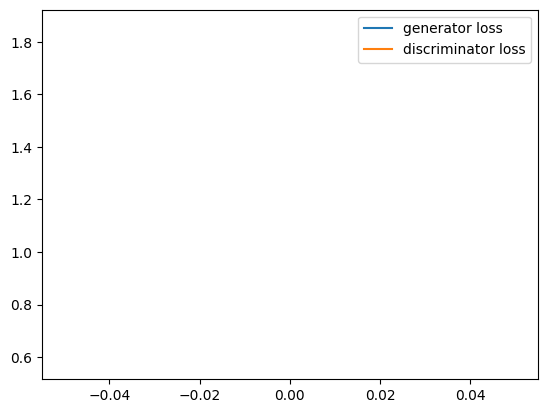

INFO:tensorflow:Assets written to: modelSaves/cifar10/cgen/training/fold_0/epoch0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/cgen/training/fold_0/epoch0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/cdisc/training/fold_0/epoch0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/cdisc/training/fold_0/epoch0\assets


KeyboardInterrupt: 

In [ ]:
cgen, cdisc, cgan = compileCGAN()
trainCGAN(cgen, cdisc, cgan)

In [ ]:
cgen.save(verifiedFolder('modelSaves/' + datasetName + '/cgen/fold_' + str(currentFold)))
cdisc.save(verifiedFolder('modelSaves/' + datasetName + '/cdisc/fold_' + str(currentFold)))
cgan.save(verifiedFolder('modelSaves/' + datasetName + '/cgan/fold_' + str(currentFold)))
'''
cgen = load_model(verifiedFolder('modelSaves/' + datasetName + '/cgen/fold_' + str(currentFold)))
cdisc = load_model(verifiedFolder('modelSaves/' + datasetName + '/cdisc/fold_' + str(currentFold)))
cgan = load_model(verifiedFolder('modelSaves/' + datasetName + '/cgan/fold_' + str(currentFold)))'''

del cdisc, cgan

INFO:tensorflow:Assets written to: modelSaves/cifar10/cgen/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/cgen/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/cdisc/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/cdisc/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/cgan/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/cgan/fold_0\assets


"\ncgen = load_model(verifiedFolder('modelSaves/' + datasetName + '/cgen/fold_' + str(currentFold)))\ncdisc = load_model(verifiedFolder('modelSaves/' + datasetName + '/cdisc/fold_' + str(currentFold)))\ncgan = load_model(verifiedFolder('modelSaves/' + datasetName + '/cgan/fold_' + str(currentFold)))"

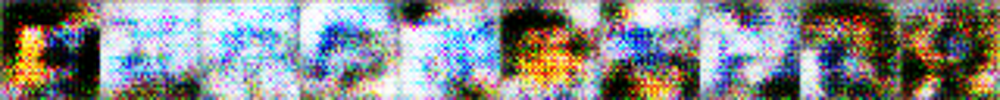

In [ ]:
noise = np.random.uniform(-1,1, size=(nClasses,100))
labels = np.array([[1 if i == j else 0 for i in range(nClasses)] for j in range(nClasses)], dtype='float32')
images = cgen.predict([noise, labels])
out = ((images * 127.5) + 127.5).astype('uint8')
showOutputAsImg(out,nClasses)
print([str(np.argmax(l)) + '       ' for l in lbls[:nClasses]])

del noise, labels, images, out

Criando classificador símples para testes

In [ ]:
def initClassifier(load = False):
    if(load):
        classifier = load_model("modelSaves/" + datasetName + "/classifier/init/fold_" + str(currentFold))
        return classifier
    else:
        classInput = keras.Input(shape=(imgWidth, imgHeight, imgChannels), name = 'classInput')
        # primeira camada convolucional, recebe formato das imagens
        classX = layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', strides=(2,2))(classInput)
        classX = layers.LeakyReLU(alpha=leakyReluAlpha)(classX)

        # segunda camada convolucional.
        classX = layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', strides=(2,2))(classX)
        classX = layers.LeakyReLU(alpha=leakyReluAlpha)(classX)

        # camada densa
        classX = layers.Flatten()(classX)
        classX = layers.Dense(discFCOutputDim)(classX)
        classX = layers.LeakyReLU(alpha=leakyReluAlpha)(classX)

        # camada de output, chassificador one hot
        classOutput = layers.Dense(nClasses, activation='sigmoid', name='genOutput_label')(classX)

        classifier = keras.Model(inputs = classInput, outputs = classOutput, name = 'classifier')

        keras.utils.plot_model(
            classifier, show_shapes= True, show_dtype = True, to_file=verifiedFolder('modelArchitecture/' + datasetName + '/classifier/fold_' + str(currentFold) + '.png')
        )

        optClass = Adam(learning_rate = initLr, beta_1 = 0.5, decay = initLr/ganEpochs)
        classifier.compile(loss='binary_crossentropy', optimizer=optClass)
        classifier.save(verifiedFolder('modelSaves/' + datasetName + '/classifier/init/fold_' + str(currentFold)))
        
        return classifier

initClassifier()

INFO:tensorflow:Assets written to: modelSaves/cifar10/classifier/init/fold_0\assets


INFO:tensorflow:Assets written to: modelSaves/cifar10/classifier/init/fold_0\assets


Funções helper para testes

In [ ]:
def generateData(nEntries):
    print("started data generation")
    genInput = np.random.uniform(-1,1,size=(nEntries,100))
    genImg, genLbl = gen.predict(genInput, verbose=0)
    print("finished data generation")
    return np.array(genImg[:nEntries]), np.array(genLbl[:nEntries])

In [ ]:
def generateDataCGAN(nEntries):
    print("started data generation")
    genInput = np.random.uniform(-1,1,size=(nEntries,100))
    genLabelInput = np.random.randint(0,nClasses, size = (nEntries))
    genLabelInput = np.array([[1 if i == li else 0 for i in range(nClasses)] for li in genLabelInput], dtype='float32')
    genImages = cgen.predict([genInput, genLabelInput])
    print("finished data generation")
    return genImages, genLabelInput

In [ ]:
def runTest(classifier):
    testImgs, testLbls = getFromDataset(0, n_instances_fold, True)
    classOutput = classifier.predict(testImgs, verbose=0)
    classOutput = [[int(np.argmax(o) == i) for i in range(nClasses)] for o in classOutput]
    print(classification_report(testLbls, classOutput))
    print('auroc score: ' + str(roc_auc_score(testLbls, classOutput)))

In [ ]:
def trainClassifier(trainName, dtst_data = False, gen_data = False, cgen_data = False, extraEpochs = 1, aug = False):
    classifier = initClassifier(True)
    classLossHist = []
    '''seq = iaa.Sequential([
        #iaa.Crop(px=(0, 5)),
        #iaa.Fliplr(0.5),
        iaa.GaussianBlur(sigma=(0, 2.0))
    ])'''

    nBatches = int((total_instances - n_instances_fold)/batchSize)
    for epoch in range(round(classifierEpochs * extraEpochs)):
        for i in range(nBatches):
            imgBatch, labelBatch = None, None
            if(dtst_data):
                imgBatch, labelBatch = getFromDataset(i*batchSize, (i+1)*batchSize)

            if(cgen_data):
                if(dtst_data):
                    cgenImgOutput, cgenLabelOutput = generateDataCGAN(batchSize)
                    imgBatch = np.concatenate((cgenImgOutput, imgBatch))
                    labelBatch = np.concatenate((cgenLabelOutput, labelBatch))
                    (imgBatch,labelBatch) = shuffle(imgBatch,labelBatch)
                    del cgenImgOutput, cgenLabelOutput
                else:
                    imgBatch, labelBatch = generateDataCGAN(batchSize)
            
            if(gen_data):
                if(dtst_data or cgen_data):
                    genImgOutput, genLabelOutput = generateData(batchSize)
                    imgBatch = np.concatenate((genImgOutput, imgBatch))
                    labelBatch = np.concatenate((genLabelOutput, labelBatch))
                    (imgBatch,labelBatch) = shuffle(imgBatch,labelBatch)
                    del genImgOutput, genLabelOutput
                else:
                    imgBatch, labelBatch = generateDataCGAN(batchSize)

            '''if(aug):
                imgBatch = seq(images=imgBatch)'''
            
            classLoss = classifier.train_on_batch(imgBatch,labelBatch)
            
            if i == nBatches-1:
                classLossHist.append(classLoss)
                IPython.display.clear_output(True)
                print("Epoch " + str(epoch) + "\nclassifier loss: " + str(classLoss))
                plotLoss([[classLossHist, 'classifier loss']])
        if(epoch % 5 == 0 or epoch == classifierEpochs * extraEpochs - 1):
            classifier.save(verifiedFolder('modelSaves/' + datasetName + '/classifier/' + trainName + '/training/fold_' + str(currentFold) + '/epoch' + str(epoch)))
    classifier.save(verifiedFolder('modelSaves/' + datasetName + '/classifier/' + trainName + '/fold_' + str(currentFold)))
    return classifier

In [ ]:
gen = load_model(verifiedFolder('modelSaves/' + datasetName + '/gen/fold_' + str(currentFold)))
cgen = load_model(verifiedFolder('modelSaves/' + datasetName + '/cgen/fold_' + str(currentFold)))

Treinando classificador com dados do dataset diretamente

Epoch 1
classifier loss: 0.22124160826206207


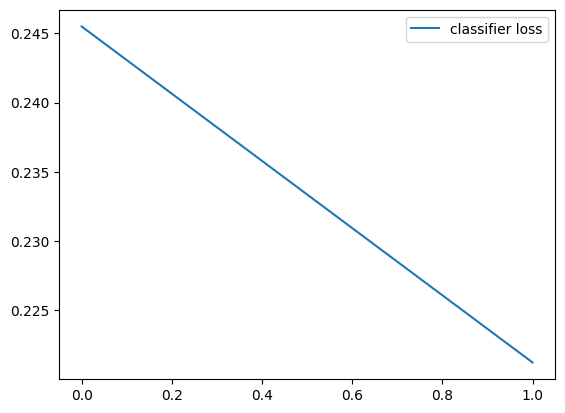

KeyboardInterrupt: 

In [ ]:
classifier = trainClassifier('none', True)
runTest(classifier)

Treinando classificador com dados aumentados com algoritmos classicos

Epoch 7
classifier loss: 0.003544798120856285


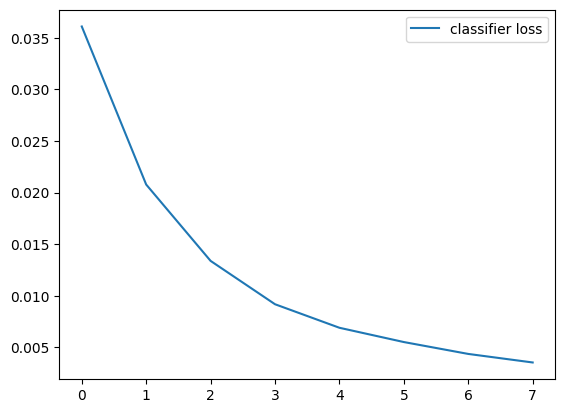

INFO:tensorflow:Assets written to: modelSaves/mnist/classifier/classic/training/fold_2/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist/classifier/classic/training/fold_2/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist/classifier/classic/fold_2\assets


INFO:tensorflow:Assets written to: modelSaves/mnist/classifier/classic/fold_2\assets


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1364
           1       0.98      0.99      0.99      1547
           2       0.98      0.98      0.98      1369
           3       0.99      0.97      0.98      1451
           4       0.98      0.99      0.99      1315
           5       0.99      0.99      0.99      1299
           6       0.99      0.99      0.99      1355
           7       0.98      0.99      0.99      1444
           8       0.98      0.98      0.98      1448
           9       0.99      0.97      0.98      1408

   micro avg       0.99      0.99      0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000
 samples avg       0.99      0.99      0.99     14000

auroc score: 0.9924596468113412


In [ ]:
classifier = trainClassifier('classic', True)
runTest(classifier)

Treinando classificador apenas com dados gerados pela GAN

Epoch 2
classifier loss: 0.067372165620327


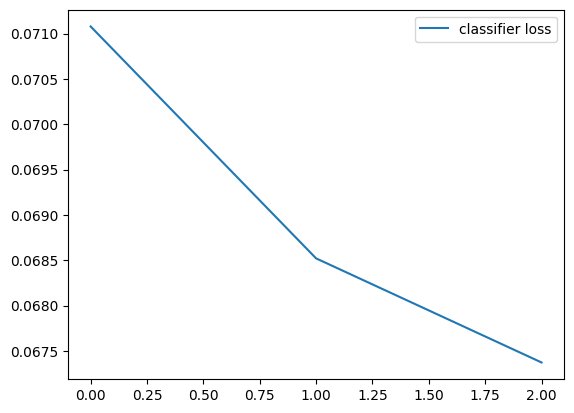

KeyboardInterrupt: 

In [ ]:
classifier = trainClassifier('gan', False, True)
runTest(classifier)

Treinando classificador apenas com dados gerados pela CGAN

Epoch 1
classifier loss: 0.11123991757631302


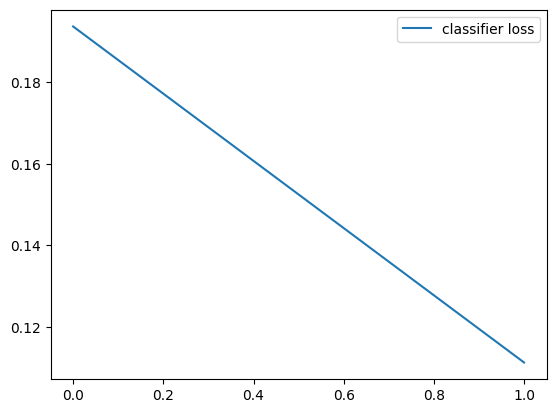

KeyboardInterrupt: 

In [ ]:
classifier = trainClassifier('cgan', False, False, True)
runTest(classifier)

Epoch 7
classifier loss: 0.001169625436887145


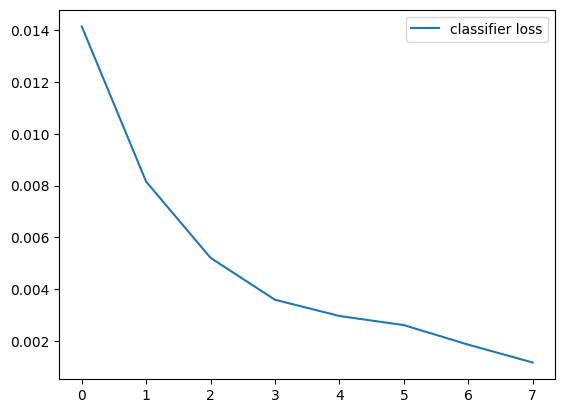

INFO:tensorflow:Assets written to: modelSaves/mnist/classifier/original+cgan/training/fold_2/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist/classifier/original+cgan/training/fold_2/epoch7\assets


INFO:tensorflow:Assets written to: modelSaves/mnist/classifier/original+cgan/fold_2\assets


INFO:tensorflow:Assets written to: modelSaves/mnist/classifier/original+cgan/fold_2\assets


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1364
           1       0.99      1.00      0.99      1547
           2       0.99      0.98      0.99      1369
           3       0.99      0.98      0.98      1451
           4       0.99      0.99      0.99      1315
           5       0.98      0.99      0.98      1299
           6       0.98      1.00      0.99      1355
           7       0.98      0.99      0.99      1444
           8       0.98      0.98      0.98      1448
           9       0.99      0.96      0.97      1408

   micro avg       0.99      0.99      0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000
 samples avg       0.99      0.99      0.99     14000

auroc score: 0.9921424801596188


In [ ]:
classifier = trainClassifier('original+cgan', True, False, True)
runTest(classifier)